In [2]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 39.1MB/s 
     |████████████████████████████████| 450kB 41.1MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (From Nov 2016)")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
import csv

day = []
value = []

with open('/content/spy.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    value.append(float(row[4]))
    day.append((row[0]))

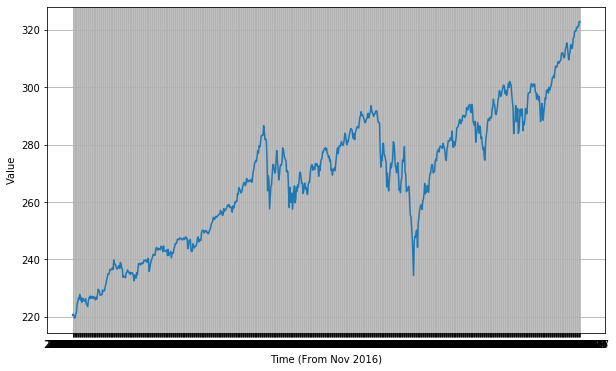

In [6]:
series = np.array(value)
time = np.array(day)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# how many time slices worth of data (5 days b/c our data is in days)
# batch size for SGD
# shuffle data so the window is not in an order that can hurt training
window_size = 10
batch_size = 20
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
# window_size = 64
# batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(600,)
Epoch 1/100
30/30 [==============================] - 4s 150ms/step - loss: 242.1361 - mae: 242.7229
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 240.8228 - mae: 241.4155
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 239.5264 - mae: 239.8596
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 237.8245 - mae: 238.1822
Epoch 5/100
30/30 [==============================] - 1s 17ms/step - loss: 235.7329 - mae: 236.3802
Epoch 6/100
30/30 [==============================] - 1s 17ms/step - loss: 233.9155 - mae: 234.4060
Epoch 7/100
30/30 [==============================] - 0s 17ms/step - loss: 231.7172 - mae: 232.2155
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 229.1784 - mae: 229.7025
Epoch 9/100
30/30 [==============================] - 1s 17ms/step - loss: 226.2908 - mae: 226.8198
Epoch 1

[1e-08, 0.0001, 0, 60]

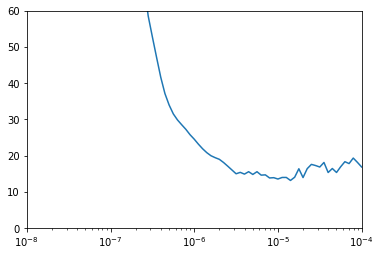

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=10, batch_size=20, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 144ms/step - loss: 141.4240 - mae: 143.7132
Epoch 2/500
30/30 [==============================] - 0s 16ms/step - loss: 20.8791 - mae: 21.3177
Epoch 3/500
30/30 [==============================] - 1s 17ms/step - loss: 16.1693 - mae: 16.6979
Epoch 4/500
30/30 [==============================] - 0s 16ms/step - loss: 16.0347 - mae: 16.6585
Epoch 5/500
30/30 [==============================] - 1s 17ms/step - loss: 16.6487 - mae: 17.0754
Epoch 6/500
30/30 [==============================] - 1s 17ms/step - loss: 16.8591 - mae: 17.3007
Epoch 7/500
30/30 [==============================] - 1s 17ms/step - loss: 15.9457 - mae: 16.4373
Epoch 8/500
30/30 [==============================] - 0s 16ms/step - loss: 15.3890 - mae: 15.9051
Epoch 9/500
30/30 [==============================] - 1s 17ms/step - loss: 15.6613 - mae: 16.1737
Epoch 10/500
30/30 [==============================] - 0s 16ms/step - loss: 15.4016 - mae: 15.8678
Epoch 11/500
30/30 [======

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

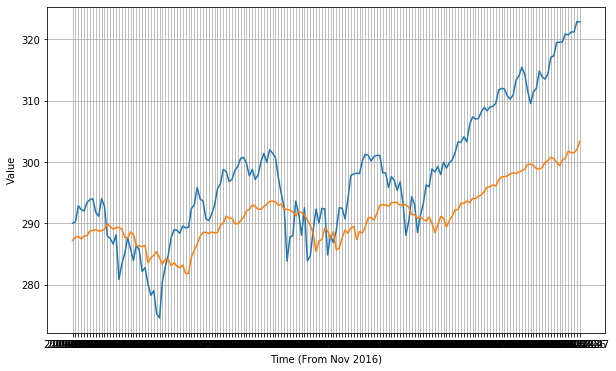

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.63194

<Figure size 432x288 with 0 Axes>

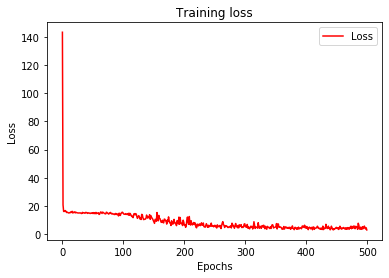

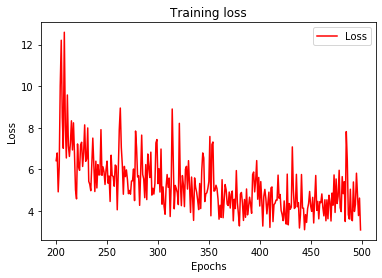

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()